# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Environment Setup

In [ ]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

In [54]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
roboflow: 1.1.12 ; supervision: 0.3.0 ; transformers: 4.35.2 ; pytorch_lightning: 2.1.2


# Load Model

In [1]:
import torch
from transformers import ConditionalDetrForObjectDetection, ConditionalDetrImageProcessor, DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50' #'facebook/detr-resnet-50' 

image_processor = ConditionalDetrImageProcessor.from_pretrained(CHECKPOINT)
model = ConditionalDetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

KeyboardInterrupt: 

# Create COCO DataLoaders

In [57]:
import os
import torchvision


# settings
dataset_location = f"D://Data//dataset"
ANNOTATION_FILE_NAME = "labels.json"
TRAIN_DIRECTORY = os.path.join(dataset_location, "train")
VAL_DIRECTORY = os.path.join(dataset_location, "val")
TEST_DIRECTORY = os.path.join(dataset_location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        dataset_directory_path: str,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(dataset_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    dataset_directory_path=f"{TRAIN_DIRECTORY}",
    image_directory_path=f"{TRAIN_DIRECTORY}//data",
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    dataset_directory_path=f"{VAL_DIRECTORY}",
    image_directory_path=f"{VAL_DIRECTORY}//data",
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    dataset_directory_path=f"{TEST_DIRECTORY}",
    image_directory_path=f"{TEST_DIRECTORY}//data",
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 25493
Number of validation examples: 2936
Number of test examples: 2913


# Visualize Data Entry

Image #19411


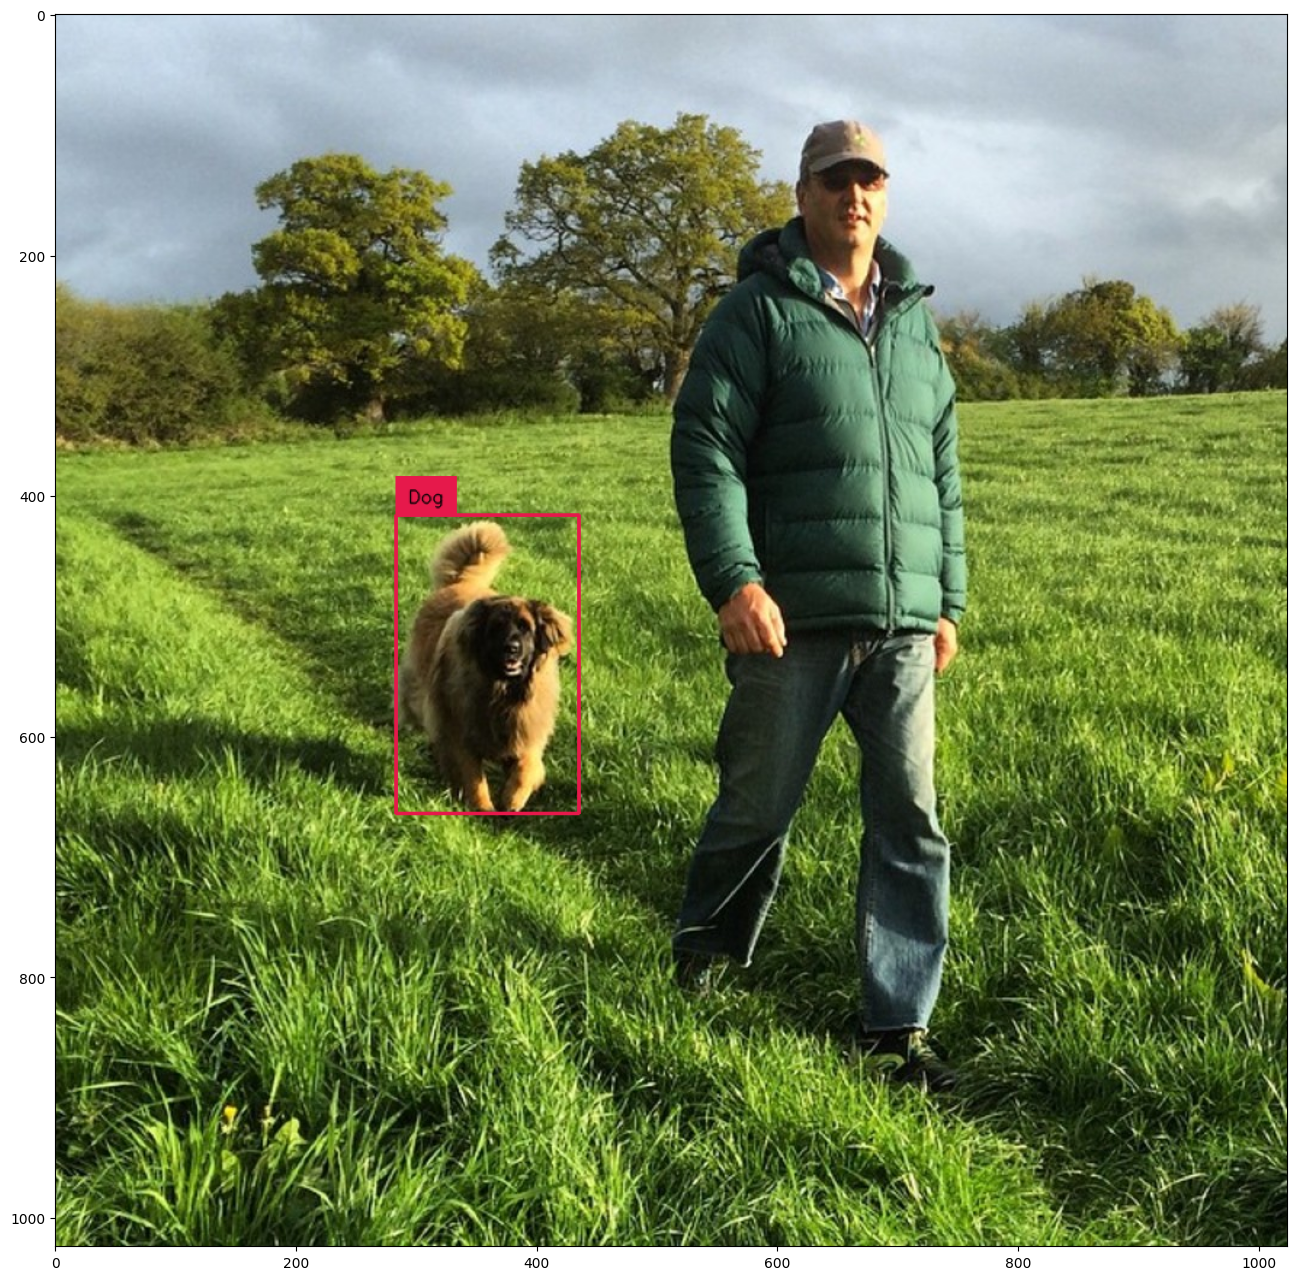

In [58]:
import random
import cv2
import numpy as np
import supervision as sv


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (16, 16))

In [62]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=8, num_workers=12, shuffle=True, pin_memory=True, persistent_workers=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=8, num_workers=12, pin_memory=True, persistent_workers=True)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=8, num_workers=24, pin_memory=True, persistent_workers=True)


# Train Model with Pytorch Lightning

In [64]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection, DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            revision = 'no_timm',
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss, on_step=True, on_epoch=True, logger=True)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss,on_step=True, on_epoch=True, logger=True)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def test_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("test_loss", loss, on_step=True, on_epoch=True, logger=True)
        for k,v in loss_dict.items():
            self.log("test_" + k, v.item())

        return loss
    
    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER
    
    def test_dataloader(self):
        return TEST_DATALOADER

In [65]:
from pytorch_lightning.loggers import TensorBoardLogger

tb_logger = TensorBoardLogger(save_dir='D:/Data/ConditionalDETR_log/')

In [61]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from pytorch_lightning import Trainer


torch.set_float32_matmul_precision('medium')
# settings
MAX_EPOCHS = 30

# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, logger=tb_logger)

trainer.fit(model,ckpt_path="/content/drive/MyDrive/Personal Colab/진현/model_save/ConditionalDETR_log/lightning_logs/version_3/checkpoints/epoch=0-step=6374.ckpt")

# Save Model from .cpkt file

In [68]:
ckpt_path = f"C://Users//jhk16//PycharmProjects//Wise_Ad-//personal//JinhyunKim//preprocess_bbox//model//conditional_epoch=29-step=98797.ckpt"
ckpt = torch.load(ckpt_path)


In [69]:
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [70]:
torch.save(model.state_dict(),'C://Users//jhk16//PycharmProjects//Wise_Ad-//personal//JinhyunKim//preprocess_bbox//model//conditional_DETR_30epochs_jinjja.pth')

In [12]:
model.load_state_dict(ckpt['state_dict'])

KeyError: 'state_dict'

# Load Model from state_dict()

In [71]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model.load_state_dict(torch.load("C://Users//jhk16//PycharmProjects//Wise_Ad-//personal//JinhyunKim//preprocess_bbox//model//conditional_DETR_30epochs_jinjja.pth"))
model.eval()

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detr(
  (model): ConditionalDetrForObjectDetection(
    (model): ConditionalDetrModel(
      (backbone): ConditionalDetrConvModel(
        (conv_encoder): ConditionalDetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): ConditionalDetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): ConditionalDetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): ConditionalDetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=T

# Inference

In [50]:
# Inference Data from DATASET
from PIL import Image
import torchvision.transforms as T
pixel_values, target = VAL_DATASET[1004]
pixel_values = pixel_values.unsqueeze(0)
pixel_values = pixel_values
image_id = target['image_id'].item()
image = VAL_DATASET.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('D://Data//dataset//val//data//', image['file_name']))
img = T.ToTensor()(image)

with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [91]:
# Inference Data from Image File
from PIL import Image
image = Image.open("C://Users//jhk16//OneDrive//문서//INISW//test.jpg").convert("RGB")

inputs = image_processor(images=image, return_tensors="pt")


with torch.no_grad():
    outputs = model(**inputs)

## Rank queries and crop image

In [92]:
import torchvision.transforms as T

# postprocess model outputs
width, height = image.size
postprocessed_outputs = image_processor.post_process_object_detection(outputs,target_sizes=[(height, width)],threshold=0.15)

    bounding_boxes = [d['boxes'] for d in postprocessed_outputs]
    cropped_images = []
    for bbox in bounding_boxes[0]:
        # Each bbox is in the format (x_min, y_min, x_max, y_max)
        left, top, right, bottom = bbox.int()

    # Calculate the height and width from the bounding box
        height = bottom - top
        width = right - left

        # Crop and add to list
        cropped_image = T.functional.crop(image, top.item(), left.item(), height.item(), width.item())
        cropped_images.append(cropped_image)

In [93]:
postprocessed_outputs

[{'scores': tensor([0.3402, 0.2216, 0.2202, 0.1995, 0.1988, 0.1859, 0.1845, 0.1725, 0.1684]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'boxes': tensor([[1255.8087,  494.8252, 1933.4021, 1273.0177],
          [1230.4496,  497.5007, 1894.7388, 1281.7096],
          [1256.3768,  506.7561, 1892.6760, 1285.4694],
          [1020.9449,  464.3293, 1928.4817, 1265.4056],
          [ 954.7465,  452.4488, 1961.7571, 1664.2836],
          [1022.3708,  467.8089, 1909.1049, 1293.9816],
          [ 988.4512,  450.2655, 1931.9808, 1433.7109],
          [1060.3297,  467.9202, 1906.2894, 1299.4648],
          [ 976.6435,  452.0053, 1924.1055, 1282.7937]])}]

In [90]:
from PIL import ImageDraw


# Draw on the image
draw = ImageDraw.Draw(image)

# Loop through each detection
for score, label, box in zip(postprocessed_outputs[0]['scores'], postprocessed_outputs[0]['labels'], postprocessed_outputs[0]['boxes']):
    box = [coordinate.item() for coordinate in box]  # Convert from tensor to list of coordinates
    draw.rectangle(box, outline="red", width=3)

    # Optionally, add the label and score
    draw.text((box[0], box[1]), f"{label.item()} ({score.item():.2f})", fill="red")

# Save or display the image
image.show()  # This will display the image
# image.save("C://Users//jhk16//OneDrive//문서//INISW//carrier_test_with_bbox.jpg")  # Save the image with bounding boxes